# ASR Assignment 2021-22

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2021-22/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/ZhaoZeyu1995/asr_labs/blob/master/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


### Import Library

In [9]:
import glob
import os
import wer
import observation_model
import openfst_python as fst
import math
import numpy as np
import time

### Generate State Table, Phone Table, Word Table from the Lexicon

In [10]:
def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex




def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
    
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))

    return word_table, phone_table, state_table




lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)

### Baseline wfst (my lab1 solution)

In [11]:
class BaselineWfst:
    
    def __init__(self, n=3, lex=lex):
        """
        Generate a HMM to recognise any single word sequence for words in the lexicon

        Args:
            n (int): states per phone HMM

        Returns:
            the constructed WFST

        """
        
        self.n = n
        self.lex = lex
        
        self.f = self.generate_wfst()
        
    
    def generate_weighted_phone_wfst(self, f, start_state, phone, n):
        """
        Generate a weighted WFST representing an n-state left-to-right phone HMM.

        Args:
            f (fst.Fst()): an FST object, assumed to exist already
            start_state (int): the index of the first state, assumed to exist already
            phone (str): the phone label 
            n (int): number of states of the HMM excluding start and end

        Returns:
            the final state of the FST
        """
    

        current_state = start_state

        for i in range(1, n+1):

            in_label = state_table.find('{}_{}'.format(phone, i))

            prev_state = current_state
            current_state = f.add_state()
            f.add_arc(prev_state, fst.Arc(in_label, 0, -math.log(0.1), prev_state))
            f.add_arc(prev_state, fst.Arc(in_label, 0, -math.log(0.9), current_state))
        
        return current_state
    
    
    def generate_wfst(self):
        """
        """
        
        f = fst.Fst()

        # create a single start state
        start_state = f.add_state()
        f.set_start(start_state)

        for word, phones in self.lex.items():
            current_state = f.add_state()
            f.add_arc(start_state, fst.Arc(0, 0, None, current_state))

            for phone in phones: 
                current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n)
            # note: new current_state is now set to the final state of the previous phone WFST
            final_state = f.add_state()
            f.set_final(final_state)
            f.add_arc(current_state, fst.Arc(0, word_table.find(word), 0, final_state))
            f.add_arc(final_state, fst.Arc(0, 0, 0, start_state))
        
        f.set_input_symbols(state_table)
        f.set_output_symbols(word_table)
        
        return f

    
    def plot(self):
        """
        """
    
        # We need special code to display the higher-resolution WFSTs inside Jupyter notebook
        from subprocess import check_call
        from IPython.display import Image    
        self.f.draw('tmp.dot', portrait=True)
        check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
        return Image(filename='tmp.png')
    

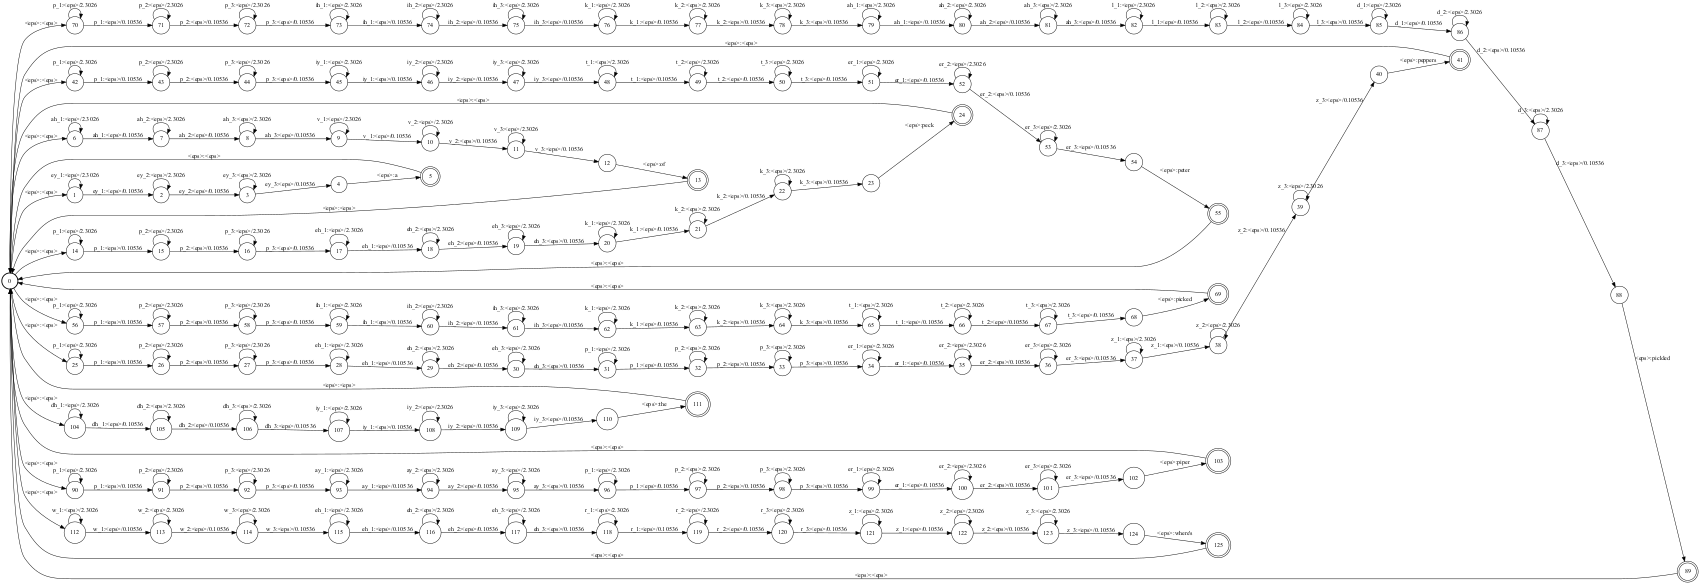

In [12]:
BaselineWfst().plot()


### Baseline Viterbi Decoder (lab3_4 solution)

In [5]:
import observation_model
import math

class BaselineViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        
        self.forward_cnt = 0
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
        
        self.forward_cnt += 1
        
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                            
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
                    
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
        
        
    def decode(self):
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
    
    def backtrace(self):
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = ' '.join([self.f.output_symbols().find(label) for label in best_out_sequence])
        
        return (best_state_sequence, best_out_sequence)


In [6]:
def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription


    
class ASR:
    
    def __init__(self, wfst, decoder, audio_file_name):
        """
        """
        self.wfst = wfst().f
        self.decoder = decoder
        self.audio_file_name = audio_file_name
        
        self.run()
    
    
    def run(self):
        """
        """
        
        
        records = []
        
        # run for each .wav file
        for wav_file in glob.glob(self.audio_file_name):    # replace path if using your own
                                                                           # audio files
            # create decoder
            decoder = self.decoder(self.wfst, wav_file)

            # measure decoding time
            start_time = time.time()
            decoder.decode()
            decode_time = time.time() - start_time
            
            # measure backtracing time
            start_time = time.time()
            (state_path, words) = decoder.backtrace()
            backtrace_time = time.time() - start_time
            
            # measure forward function counts in the decoding process
            forward_cnt = decoder.forward_cnt

            
            # measure WER accuracy
            transcription = read_transcription(wav_file)
            (sub_cnt, del_cnt, ins_cnt) = wer.compute_alignment_errors(transcription, words)
            word_cnt = len(transcription.split())
            accuracy = sum([sub_cnt, del_cnt, ins_cnt])/word_cnt
            
            
            # print results for each .wav file
            print(wav_file)
            print('Transcription: ' + transcription)
            print('Prediction: ' + words)
            print('Substiution: {}, Deletion: {}, Insertion: {}, Number of words: {}, Accuracy: {:.3f}'
                  .format(sub_cnt, del_cnt, ins_cnt, word_cnt, accuracy))
            print()
            
            
            # save the measurements
            records.append([sub_cnt, del_cnt, ins_cnt, word_cnt, accuracy, decode_time, backtrace_time, forward_cnt])
        
        # average measuerments
        self.sub_cnt, self.del_cnt, self.ins_cnt, self.word_cnt, self.accuracy, self.decode_time, self.backtrace_time, self.forward_cnt = np.average(records, axis=0)
        
        
        
        
    def print_accuracy(self):
        """
        """
        print('-- Accuracy Info  *All Average Values* -------------------------------------------------------------')
        print('| Substiution: {:.3f}, Deletion: {:.3f}, Insertion: {:.3f}, Number of words: {:.3f}, Accuracy: {:.3f} |'
              .format(self.sub_cnt, self.del_cnt, self.ins_cnt, self.word_cnt, self.accuracy))
        print('----------------------------------------------------------------------------------------------------')
        
        
    def print_speed(self):
        """
        """
        
        print('-- Speed Info  *All Average Values* ----------------------------------------------------------------')
        print('| Decoding time: {:.3f}s, Backtracing time: {:.3f}s, Number of forward computations: {:.3f}        |'
              .format(self.decode_time, self.backtrace_time, self.forward_cnt))
        print('----------------------------------------------------------------------------------------------------')
    
    def print_memory(self):
        """
        """
        
        num_arcs = 0
        for state in self.wfst.states():
            num_arcs += self.wfst.num_arcs(state)
            
        print('-- Memory Info -------------------------------------------------------------------------------------')
        print('| Number of states: {}, Number of arcs: {}                                                       |'
              .format(self.wfst.num_states(), num_arcs))
        print('----------------------------------------------------------------------------------------------------')

        
    def print_all(self):
        """
        """
        
        self.print_accuracy()
        self.print_speed()
        self.print_memory()

In [7]:
asr = ASR(BaselineWfst, BaselineViterbiDecoder, '/group/teaching/asr/labs/recordings/*.wav')
asr.print_all()

/group/teaching/asr/labs/recordings/0000.wav
Transcription: of of a peter the piper the pickled
Prediction: peck the the a of a of the of peter the peck a a of picked a a piper pickled the the pickled picked the the a
Substiution: 1, Deletion: 0, Insertion: 19, Number of words: 8, Accuracy: 2.500

/group/teaching/asr/labs/recordings/0001.wav
Transcription: piper peck peppers peter peter picked pickled peck peter piper
Prediction: peck the the the the the the the the the the a peter of a a peppers a peter peter picked picked pickled peck the the peter picked piper picked the picked the
Substiution: 0, Deletion: 1, Insertion: 24, Number of words: 10, Accuracy: 2.500

/group/teaching/asr/labs/recordings/0002.wav
Transcription: peck of peck pickled pickled picked piper peck picked a
Prediction: picked the the the the a pickled a picked pickled pickled picked picked the piper peck picked the picked pickled picked picked picked the the the picked
Substiution: 4, Deletion: 0, Insertion: 17, N

/group/teaching/asr/labs/recordings/0026.wav
Transcription: a peck of pickled peppers peter piper picked
Prediction: picked the the the the the the picked pickled pickled picked where's peter of piper picked a a picked picked the the the the the the a
Substiution: 4, Deletion: 0, Insertion: 19, Number of words: 8, Accuracy: 2.875

/group/teaching/asr/labs/recordings/0027.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: picked the the the the of of of picked of a the the of where's picked where's the a of picked of peppers peter piper of picked picked the picked picked the the the the the
Substiution: 7, Deletion: 0, Insertion: 19, Number of words: 17, Accuracy: 1.529

/group/teaching/asr/labs/recordings/0028.wav
Transcription: where's the peppers peter picked
Prediction: peck the the the the the the the the the pickled where's pickled where's picked peter peck a a picked picked the the the the the the the

/group/teaching/asr/labs/recordings/0053.wav
Transcription: peter piper picked
Prediction: picked a the the the the peck peter pickled piper pickled peck picked picked the picked picked peck peck
Substiution: 0, Deletion: 0, Insertion: 16, Number of words: 3, Accuracy: 5.333

/group/teaching/asr/labs/recordings/0054.wav
Transcription: peter piper picked peter piper picked
Prediction: picked of picked picked pickled peter of a a picked picked picked the the the the the the the picked
Substiution: 3, Deletion: 0, Insertion: 14, Number of words: 6, Accuracy: 2.833

/group/teaching/asr/labs/recordings/0055.wav
Transcription: a peck of pickled peppers of peter
Prediction: the of peck of pickled peck of where's of peter picked the the the the picked picked
Substiution: 2, Deletion: 0, Insertion: 10, Number of words: 7, Accuracy: 1.714

/group/teaching/asr/labs/recordings/0056.wav
Transcription: where's the peck of pickled peppers piper picked
Prediction: picked the the the where's the of pec

/group/teaching/asr/labs/recordings/0082.wav
Transcription: the pickled peppers of the piper peter
Prediction: picked the of of the pickled where's of the piper peter picked picked picked
Substiution: 1, Deletion: 0, Insertion: 7, Number of words: 7, Accuracy: 1.143

/group/teaching/asr/labs/recordings/0083.wav
Transcription: where's peter piper
Prediction: a the the where's peter of piper picked
Substiution: 0, Deletion: 0, Insertion: 5, Number of words: 3, Accuracy: 1.667

/group/teaching/asr/labs/recordings/0084.wav
Transcription: the piper picked the peppers of peter
Prediction: picked the of piper of picked of peppers of peter the picked the
Substiution: 1, Deletion: 0, Insertion: 6, Number of words: 7, Accuracy: 1.000

/group/teaching/asr/labs/recordings/0085.wav
Transcription: peck pickled peck piper
Prediction: peter where's where's the the the peck the pickled peck picked of peter picked the
Substiution: 1, Deletion: 0, Insertion: 11, Number of words: 4, Accuracy: 3.000

/grou

/group/teaching/asr/labs/recordings/0109.wav
Transcription: peck peter peppers pickled picked pickled peppers peter peck peck peter peppers pickled picked pickled peppers peter peck
Prediction: picked the the piper where's the the the where's the the the the the the the the the picked piper peter piper pickled peter pickled piper peter picked picked picked piper peter picked the pickled of piper the pickled picked peter picked piper pickled picked the the the the picked picked piper peter piper picked picked the the the the the the the the picked the
Substiution: 9, Deletion: 0, Insertion: 48, Number of words: 18, Accuracy: 3.167

/group/teaching/asr/labs/recordings/0110.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: picked the the the the picked the peter of piper picked picked piper a of pickled peck where's picked where's the peck picked picked of pickled peppers peter of piper picked picked the pick

/group/teaching/asr/labs/recordings/0130.wav
Transcription: piper peck a pickled the pickled peppers
Prediction: picked the piper of peck a pickled the pickled peck where's picked the the picked the the
Substiution: 1, Deletion: 0, Insertion: 10, Number of words: 7, Accuracy: 1.571

/group/teaching/asr/labs/recordings/0131.wav
Transcription: piper piper a peter picked a peter
Prediction: picked the the piper of piper where's a peter picked a peter picked peck the the the the a the
Substiution: 0, Deletion: 0, Insertion: 13, Number of words: 7, Accuracy: 1.857

/group/teaching/asr/labs/recordings/0132.wav
Transcription: where's the peter peck
Prediction: picked the where's the peter of peck picked the the the picked
Substiution: 0, Deletion: 0, Insertion: 8, Number of words: 4, Accuracy: 2.000

/group/teaching/asr/labs/recordings/0133.wav
Transcription: picked peter a peck of pickled pickled peppers
Prediction: picked the the peter picked a peck picked pickled pickled peck of where's th

/group/teaching/asr/labs/recordings/0156.wav
Transcription: of peter peppers pickled peppers peter pickled
Prediction: picked the the the the of peter picked of where's pickled peppers peter pickled the the
Substiution: 1, Deletion: 0, Insertion: 9, Number of words: 7, Accuracy: 1.429

/group/teaching/asr/labs/recordings/0157.wav
Transcription: peppers peck picked
Prediction: picked the the the peppers peck a a where's picked the where's picked the
Substiution: 0, Deletion: 0, Insertion: 11, Number of words: 3, Accuracy: 3.667

/group/teaching/asr/labs/recordings/0158.wav
Transcription: where's the picked peter piper of of peck picked a piper peppers pickled peck peter peppers pickled
Prediction: picked the the where's the picked peter of piper a a of of peck picked of piper peppers pickled peck peter of of where's pickled picked picked picked
Substiution: 2, Deletion: 0, Insertion: 11, Number of words: 17, Accuracy: 0.765

/group/teaching/asr/labs/recordings/0159.wav
Transcription: wh

/group/teaching/asr/labs/recordings/0186.wav
Transcription: piper pickled picked peter
Prediction: picked the the piper peck pickled picked peter of picked picked the the picked
Substiution: 0, Deletion: 0, Insertion: 10, Number of words: 4, Accuracy: 2.500

/group/teaching/asr/labs/recordings/0187.wav
Transcription: pickled the a picked piper where's peppers
Prediction: picked the the the pickled the of of picked piper where's peppers picked the the
Substiution: 1, Deletion: 0, Insertion: 8, Number of words: 7, Accuracy: 1.286

/group/teaching/asr/labs/recordings/0188.wav
Transcription: peter picked pickled peppers
Prediction: peck the peck peter of a peck pickled piper where's picked the the the the the the
Substiution: 2, Deletion: 0, Insertion: 13, Number of words: 4, Accuracy: 3.750

/group/teaching/asr/labs/recordings/0189.wav
Transcription: peppers picked peter
Prediction: picked the the peck peck where's picked peter picked picked the the the
Substiution: 1, Deletion: 0, Insert

/group/teaching/asr/labs/recordings/0215.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: picked the peter of peck a of where's peter of the a a a a a a pickled of pickled peppers picked picked where's the of peck pickled pickled peppers peter piper peter picked
Substiution: 4, Deletion: 0, Insertion: 17, Number of words: 17, Accuracy: 1.235

/group/teaching/asr/labs/recordings/0216.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: peck the picked peter of piper pickled pickled piper pickled picked where's where's picked a a a pickled pickled peppers peter piper peter the the the
Substiution: 8, Deletion: 1, Insertion: 10, Number of words: 17, Accuracy: 1.118

/group/teaching/asr/labs/recordings/0217.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Predicti

/group/teaching/asr/labs/recordings/0242.wav
Transcription: pickled peppers a peck of peter
Prediction: the the the the pickled peppers peck of peter of picked picked
Substiution: 0, Deletion: 1, Insertion: 7, Number of words: 6, Accuracy: 1.333

/group/teaching/asr/labs/recordings/0243.wav
Transcription: peter pickled peppers
Prediction: picked the the peter pickled peppers picked the the the the
Substiution: 0, Deletion: 0, Insertion: 8, Number of words: 3, Accuracy: 2.667

/group/teaching/asr/labs/recordings/0244.wav
Transcription: where's the pickled peppers peter piper picked
Prediction: picked picked the picked where's the pickled peppers peter picked picked the the the the the the the where's
Substiution: 1, Deletion: 0, Insertion: 12, Number of words: 7, Accuracy: 1.857

/group/teaching/asr/labs/recordings/0245.wav
Transcription: peter piper picked a peck of pickled peppers
Prediction: a picked the picked peter piper picked of picked of pickled peppers the picked the the the th

/group/teaching/asr/labs/recordings/0267.wav
Transcription: peter piper picked a peck of peppers where's the peck of pickled peppers
Prediction: picked the picked of piper picked where's of peck of peck picked where's picked the where's picked of peck of pickled picked peppers picked the a
Substiution: 3, Deletion: 0, Insertion: 13, Number of words: 13, Accuracy: 1.231

/group/teaching/asr/labs/recordings/0268.wav
Transcription: peter picked a peck of pickled peppers
Prediction: picked the the the the the picked peter of peck picked the of piper pickled picked pickled picked peppers the the
Substiution: 2, Deletion: 0, Insertion: 14, Number of words: 7, Accuracy: 2.286

/group/teaching/asr/labs/recordings/0269.wav
Transcription: pickled peppers
Prediction: picked the the the the pickled picked peppers picked picked
Substiution: 0, Deletion: 0, Insertion: 8, Number of words: 2, Accuracy: 4.000

/group/teaching/asr/labs/recordings/0270.wav
Transcription: peter piper picked peppers
Predic

/group/teaching/asr/labs/recordings/0291.wav
Transcription: the peck of pickled peppers of peter piper
Prediction: picked the the the the picked where's of peck of pickled picked where's of peter of piper the picked the the picked
Substiution: 1, Deletion: 0, Insertion: 14, Number of words: 8, Accuracy: 1.875

/group/teaching/asr/labs/recordings/0292.wav
Transcription: where's peter piper
Prediction: picked the the the picked where's where's peter of piper the picked the the the the
Substiution: 0, Deletion: 0, Insertion: 13, Number of words: 3, Accuracy: 4.333

/group/teaching/asr/labs/recordings/0293.wav
Transcription: a peck peppers where's picked peter of pickled of peppers peck the piper picked peter piper pickled
Prediction: picked the the the the the the the the the picked the the where's picked the of of picked of of where's where's picked a a picked picked the of peppers picked pickled pickled peppers picked the peck peck the piper peter picked picked picked peter of piper of 

/group/teaching/asr/labs/recordings/0316.wav
Transcription: where's the peppers peter piper picked
Prediction: peck the pickled where's of piper where's peter piper picked peck the
Substiution: 2, Deletion: 0, Insertion: 6, Number of words: 6, Accuracy: 1.333

/group/teaching/asr/labs/recordings/0317.wav
Transcription: peter piper picked a peck of pickled peppers
Prediction: picked the peter of piper of picked the of pickled pickled piper where's picked the picked
Substiution: 2, Deletion: 1, Insertion: 9, Number of words: 8, Accuracy: 1.500

/group/teaching/asr/labs/recordings/0318.wav
Transcription: where's the peck of pickled peppers peter piper picked
Prediction: picked the of where's of pickled of pickled peppers peter the piper of picked picked the the the
Substiution: 2, Deletion: 0, Insertion: 9, Number of words: 9, Accuracy: 1.222

/group/teaching/asr/labs/recordings/0319.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter 

/group/teaching/asr/labs/recordings/0340.wav
Transcription: peter piper picked a peck
Prediction: picked the the of peter picked the piper the a picked the of picked picked the picked picked the the
Substiution: 2, Deletion: 0, Insertion: 15, Number of words: 5, Accuracy: 3.400

/group/teaching/asr/labs/recordings/0341.wav
Transcription: peppers peck peter piper
Prediction: the picked where's peck picked the of the the of picked piper picked picked the the the the the
Substiution: 2, Deletion: 0, Insertion: 15, Number of words: 4, Accuracy: 4.250

/group/teaching/asr/labs/recordings/0342.wav
Transcription: peter peter peter peter
Prediction: the where's the the the the the the picked of the peck picked the the the the
Substiution: 4, Deletion: 0, Insertion: 13, Number of words: 4, Accuracy: 4.250

/group/teaching/asr/labs/recordings/0343.wav
Transcription: piper pickled pickled peppers
Prediction: picked the the of piper the peck where's picked the of pickled of peppers picked the the 